# Geometria do lote fiscal a partir do serviço WMS do GeoSampa

Os lotes fiscais estão disponíveis no [GeoSampa](http://geosampa.prefeitura.sp.gov.br) mas também pode ser acessador por serviço WMS

In [1]:
from owslib.wms import WebMapService

url_wms = 'http://wms.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/wms'

wms = WebMapService(url_wms, version='1.3.0')

print(wms['lote_cidadao'].title)
print(wms['lote_cidadao'].crs_list)
print(wms['lote_cidadao'].abstract)

lote_cidadao
[(-47.47849807885537, -24.19376329804249, -45.773692681083574, -23.137814287792693, 'CRS:84'), (248200.0, 7324100.0, 420800.0, 7439100.0, 'EPSG:31983')]
Lotes fiscais com informações de zoneamento. A Lei de Zoneamento estabelece normas complementares ao Plano Diretor Estratégico, institui os Planos Regionais Estratégicos das Subprefeituras, dispõe sobre o parcelamento, disciplina e ordena o Uso e Ocupação do Solo do Município de São Paulo. Os valores de zoneamento, estabelecido na Lei nº 13.885/2004, foram agregados as feições de lotes através dos números de setor, quadra e lote , tendo como base cartográfica o Mapa Digital da Cidade e as informações fiscais da Secretaria de Finanças.


## Feição do lote

A partir de uma coordenada geográfica ou UTM podemos obter os dados de uma feição.

Para tanto usamos um recurso de desenhar uma caixa como bounding box (bbox). No caso, como estamos trabalhando com coordenadas UTM, a unidade é o metro. Precisamos de uma caixa pequena o suficiente para caber dentro da feição que desejamos. 

In [2]:
c = (333087.92005983833, 7395132.272480484)

lote = wms.getfeatureinfo(layers = ['lote_cidadao'],
                          format = 'image/png',
                          info_format = 'application/json',
                          srs = 'EPSG:31983',
                          bbox = (c[0] - 1, c[1] - 1, c[0] + 1, c[1] + 1),
                          size = (2, 2), 
                          xy = (1, 1))

Se tudo deu certo a linha a seguir retorna a URL para obtenção da resposta com as informações do lote caso seja encontrado

In [4]:
lote.geturl()

'http://wms.geosampa.prefeitura.sp.gov.br:80/geoserver/geoportal/ows?SERVICE=WMS&service=WMS&version=1.3.0&request=GetFeatureInfo&layers=lote_cidadao&styles=&width=2&height=2&crs=EPSG%3A31983&bbox=333086.92005983833%2C7395131.272480484%2C333088.92005983833%2C7395133.272480484&format=image%2Fpng&transparent=FALSE&bgcolor=0xFFFFFF&exceptions=XML&query_layers=lote_cidadao&i=1&j=1&info_format=application%2Fjson&feature_count=20'

In [5]:
import json
lote_json = json.load(lote)

In [6]:
from shapely.geometry import Polygon
polygon = Polygon(lote_json['features'][0]['geometry']['coordinates'][0])

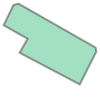

In [7]:
display(polygon)

## Convertendo coordenadas geográficas em UTM

Frequentemente precisamos converter coordenadas Geográficas (Lat e Long) WGS84 em UTM SIRGAS 2000

In [8]:
coords_wgs84 = [-23.545567989349365, -46.6351979970932]

In [9]:
from pyproj import Proj, transform

def geo2utm(coord_geo):
    in_proj  = Proj("EPSG:4326")
    out_proj = Proj("EPSG:31983")
    y1, x1 = coord_geo
    return transform(in_proj, out_proj, y1, x1)

In [10]:
geo2utm(coords_wgs84)

(333087.92005983833, 7395132.272480484)

Para facilitar o desenho da feição no mapa, vamos encapsular os procedimentos nas funções abaixo

In [12]:
# encapsulando a obtenção de coordenadas de polígono do lote

from shapely.geometry import Point, box

def get_bb_from_point(p):
    bb = Point(p[0], p[1]).buffer(0.000001).bounds
#     return list(box(bb[0], bb[1], bb[2], bb[3]).exterior.coords)
    return bb

def get_polygon_coord(coordinate):
    c = coordinate
    s = 0.25
    lote = wms.getfeatureinfo(layers = ['lote_cidadao'],
                          format = 'image/png',
                          info_format = 'application/json',
                          srs = 'EPSG:31983',
                          bbox = (c[0] - s, c[1] - s, c[0] + s, c[1] + s),
                          size = (2, 2), 
                          xy = (1, 1))
    lote_json = json.load(lote)
#     print(lote_json)
    return lote_json['features'][0]['geometry']['coordinates'][0]
    

## Visualizando e escolhendo um lote fiscal a partir de uma visualização de mapa

Agora vamos visualizar a camada de 'lotes' sobre o 'mapa base' e disponibilizar um marcador que ao ser movido sobre o lote desejado, devolve a feição do lote quando clicado.

Label(value='')

Map(center=[-23.545567989349365, -46.6351979970932], controls=(ZoomControl(options=['position', 'zoom_in_text'…

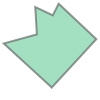

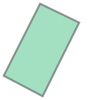

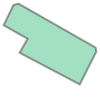

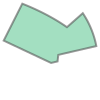

In [13]:
from ipyleaflet import Map, WMSLayer, basemaps, Marker, WidgetControl, Polygon as LeafLetPolygon
from ipywidgets import Label

center = coords_wgs84

mapa_base = WMSLayer(
    url = url_wms,
    layers = 'MapaBase_Politico',
    format = 'image/png',
    transparent = True,
    attribution = 'GeoSampa'
)

lotes = WMSLayer(
    url = 'http://wms.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/wms',
    layers = 'lote_cidadao',
    format = 'image/png',
    transparent = True,
    attribution = 'GeoSampa'
)

m = Map(center=center, 
        zoom=17,
       scroll_wheel_zoom = True)

m.add_layer(mapa_base)
m.add_layer(lotes)

marker = Marker(location=center, draggable=True)
m.add_layer(marker)

from pyproj import Transformer
transformer = Transformer.from_crs(31983, 4326)

def handle_click(*args, **kwargs):
    lote_xy = geo2utm(marker.location)
    poligono_coord = get_polygon_coord(lote_xy)
#     print(list(transformer.itransform(poligono_coord)))
#     print(poligono_coord)
    poligono = LeafLetPolygon(locations=list(transformer.itransform(poligono_coord)), 
                              color="green", 
                              fill_color="green")
    m.add_layer(poligono)
    display(Polygon(poligono_coord))

marker.on_click(handle_click)

label = Label()
display(label)

def handle_interaction(**kwargs):
    label.value = str(kwargs)

m.on_interaction(handle_interaction)

# m.layout.width = '900px'
# m.layout.height = '450px'

m

In [34]:
marker.location

[-23.543250560760498, -46.63402855396271]